In [98]:
import numpy as np
import cv2 
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 7)

videofile = './Novgorod_2019-04-05-15_15_00.mp4'


(3008, 4112, 3)

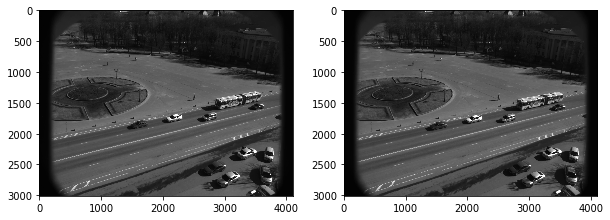

In [119]:
cap = cv2.VideoCapture(videofile)
ret, first_frame = cap.read()
ret, sec_frame = cap.read()
cap.release()
plt.subplot(1,2,1)
plt.imshow(first_frame)
plt.subplot(1,2,2)
plt.imshow(sec_frame)
first_frame.shape

(3008, 4112)

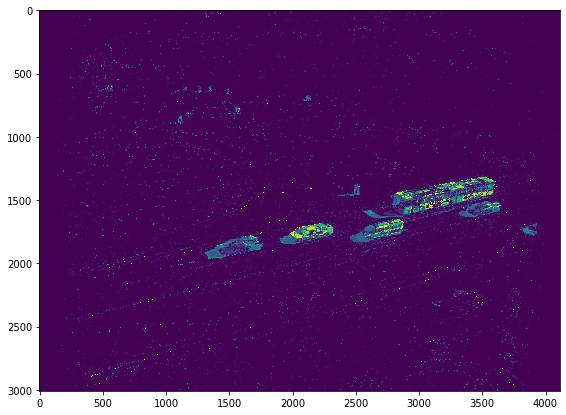

In [120]:
diff_im = cv2.bitwise_xor(first_frame, sec_frame)
diff_im = cv2.cvtColor(diff_im, cv2.COLOR_BGR2GRAY)
# diff_im = diff_im[:,:,0]
plt.imshow(diff_im)
diff_im.shape

In [139]:
resized = cv2.resize(diff_im, dsize=(diff_im.shape[1]//4, diff_im.shape[0]//4))
resized.shape

(752, 1028)

In [122]:
# blured = cv2.blur(resized, (5,5))
с = cv2.medianBlur(resized, 21)
# blured = cv2.GaussianBlur(blured,(9,9),0)
# i = 10
# blured = cv2.bilateralFilter(blured, i, i*2, i/2)    
plt.imshow(blured, cmap=plt.cm.Greys_r)

NameError: name 'blured' is not defined

In [ ]:
plt.imshow(cv2.findContours(blured/256, cv2.RETR_TREE, cv2.CHAIN_APPROX_TC89_KCOS ))

In [ ]:
k = 6
kern_shape = (k, k+1)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (6, 7))
print(kern_shape)
blured_r = cv2.medianBlur(resized, 11)
for i in range(10):
    blured_r = cv2.medianBlur(blured_r, 7)
eroded = cv2.erode(blured_r, kernel, iterations=3)
plt.figure(figsize=(17, 10))
plt.subplot(1, 2, 1)
plt.imshow(blured_r, cmap=plt.cm.Greys_r)
plt.subplot(1, 2, 2)
plt.imshow(eroded, cmap=plt.cm.Greys_r)

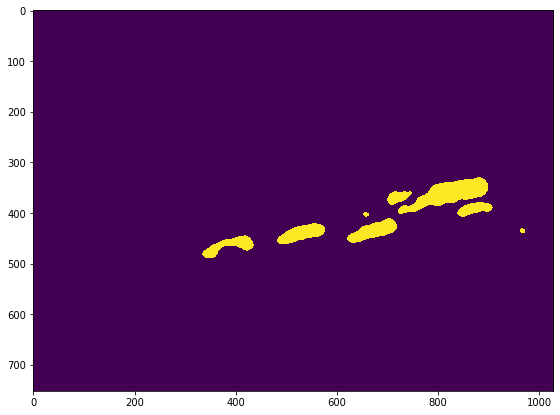

In [142]:
ret, thresh = cv2.threshold(blured_r, 0, blured_r.max(), cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.imshow(thresh)


In [133]:
def get_centroid(x, y, w, h):
    x1 = int(w / 2)
    y1 = int(h / 2)
    cx = x + x1
    cy = y + y1
    return (cx, cy)

def detect_vehicles(fg_mask, min_contour_width=35, min_contour_height=35):

    matches = []

    # finding external contours
    contours, hierarchy = cv2.findContours(
        fg_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_L1)
    # filtering by with, height
    for (i, contour) in enumerate(contours):
        (x, y, w, h) = cv2.boundingRect(contour)
        contour_valid = (w >= min_contour_width) and (
            h >= min_contour_height)
        if not contour_valid:
            continue
        # getting center of the bounding box
        centroid = get_centroid(x, y, w, h)
        matches.append(contour)
    return matches


8
[[[416 445]]

 [[411 446]]

 [[410 447]]

 [[404 447]]

 [[401 448]]

 [[398 450]]

 [[395 451]]

 [[391 452]]

 [[379 452]]

 [[376 453]]

 [[373 454]]

 [[365 458]]

 [[363 460]]

 [[361 461]]

 [[359 461]]

 [[356 462]]

 [[352 464]]

 [[349 466]]

 [[345 469]]

 [[342 471]]

 [[339 473]]

 [[336 476]]

 [[334 480]]

 [[334 482]]

 [[335 484]]

 [[339 488]]

 [[342 489]]

 [[347 489]]

 [[356 488]]

 [[361 484]]

 [[363 482]]

 [[365 478]]

 [[365 476]]

 [[366 474]]

 [[368 471]]

 [[371 468]]

 [[374 466]]

 [[376 465]]

 [[379 464]]

 [[387 465]]

 [[390 465]]

 [[399 464]]

 [[402 465]]

 [[407 468]]

 [[409 468]]

 [[411 469]]

 [[413 471]]

 [[417 473]]

 [[420 474]]

 [[424 474]]

 [[427 473]]

 [[430 471]]

 [[434 467]]

 [[435 465]]

 [[435 461]]

 [[434 458]]

 [[433 456]]

 [[431 453]]

 [[427 449]]

 [[424 447]]

 [[422 446]]

 [[419 445]]]
[[336 492]
 [329 462]
 [430 441]
 [437 471]]


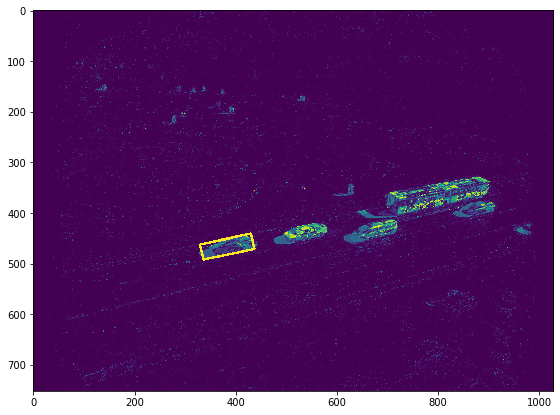

In [132]:
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_L1)
print(len(contours))
cnt = contours[0]
rect = cv2.minAreaRect(cnt)
print(cnt)
box = cv2.boxPoints(rect)
box = np.int0(box)
print(box)
plt.imshow(cv2.drawContours(resized.copy(),[box],0,(255,0,255),4))

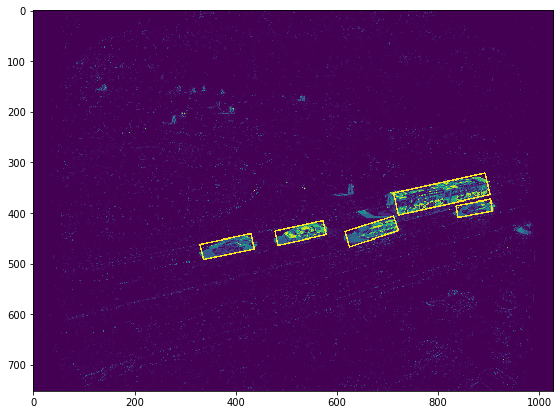

In [141]:
objects = detect_vehicles(thresh, 30, 30)
boxes = [np.int0(cv2.boxPoints(cv2.minAreaRect(cnt))) for cnt in objects]

plt.imshow(cv2.drawContours(resized.copy(), boxes, -1, (255,0,0), 2))

# for i in range(len(points)):
#     plt.scatter(points[i][1][0], points[i][1][1])
# 

In [164]:
def get_frame(frame1, frame2, size):
    diff_frame = cv2.bitwise_xor(frame1, frame2)
    diff_frame = cv2.cvtColor(diff_frame, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(diff_frame, dsize=size)
    
    blured_r = cv2.medianBlur(resized, 11)
    for i in range(10):
        blured_r = cv2.medianBlur(blured_r, 7)
    
    ret, thresh = cv2.threshold(blured_r, 0, blured_r.max(), cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    objects = detect_vehicles(thresh, 30, 30)
    boxes = [np.int0(cv2.boxPoints(cv2.minAreaRect(cnt))) for cnt in objects]
    
    sure_fg = cv2.drawContours(resized.copy(), boxes, -1, (255,0,0), 2)
    
#     print(sure_fg, frame2.shape)
    
#     sure_fg = cv2.resize(sure_fg, frame2.shape[:2][::-1])
    
    return frame2, sure_fg

In [ ]:
cap = cv2.VideoCapture(videofile)
ret, frame1 = cap.read()
while cap.isOpened():
    try:
        ret, frame2 = cap.read()    
        frame1, new_frame = get_frame(frame1, frame2, (1024, 1024))  
#         print(new_frame)
#         plt.imshow(new_frame)
#         break
        cv2.imshow('video', new_frame)
        key = cv2.waitKey(1)
        if key & 0xFF == ord('q'):
            cv2.destroyAllWindows()
            cap.release()
            break
    except Exception(e):
        print(e)
        cv2.destroyAllWindows()
        break
cap.release()

In [138]:
(tmp_morph[:,:,1]>15).astype(np.uint8)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)